In [1]:
! pip install -q --no-index --find-links=file:///kaggle/input/contrails-base-model/pip \
    segmentation_models_pytorch
! cp -r /kaggle/input/contrails-base-model/src ./src

In [2]:
from typing import Tuple


def get_range(ra: str, n: int) -> Tuple[int, int]:
    """
    istart, iend = get_range('1:10', n)

    Args:
      ra (str or None): 1, 1:, 5:10
      n (int): default iend when it is omitted, ra = '1:'
    """

    if ra is None:
        return 0, n
    elif ra.isnumeric():
        # Single number
        i = int(ra)
        return i, i + 1
    elif ':' in ra:
        v = ra.split(':')
        assert len(v) == 2
        istart = 0 if v[0] == '' else int(v[0])
        iend = n if v[1] == '' else int(v[1])
        return istart, iend
    else:
        raise ValueError('Failed to parse range: {}'.format(ra))


def as_list(s, *, dtype=int):
    """
    Parse string of numbers to list of numbers

    Arg:
      s (str): '1,2,4...7' => [1, 2, 4, 5, 6, 7]
    """
    ret = []
    if not isinstance(s, str):
        return [dtype(s), ]

    for seg in s.split(','):
        if dtype is int and '...' in seg:
            start, last = map(int, seg.split('...'))
            for i in range(start, last):
                ret.append(dtype(i))
        else:
            ret.append(dtype(seg))

    return ret

In [3]:
import numpy as np
import pandas as pd
import os
import sys
import glob
import time
import yaml
from tqdm.auto import tqdm
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss

import torchvision.transforms as T
import albumentations as A
import segmentation_models_pytorch as smp

sys.path.append('/kaggle/working/src')
# import util
from lr_scheduler import Scheduler
from submit import write_submission


di = '/kaggle/input/contrails-valid/'
device = torch.device('cuda')

In [4]:
cfg = yaml.safe_load("""
data:
  resize: 512          # maxvit_tiny_tf_512
  augment: rotation    
  augment_prob: 0.95    

model:
  encoder: tu-maxvit_tiny_tf_512.in1k   # timm-resnest26d
  pretrained: False    
  decoder_channels: [256, 128, 64, 32, 16]

kfold:
  k: 10
  folds: 0  # 0,1,2,3,4

train:
  batch_size: 4        
  weight_decay: 1e-2
  clip_grad_norm: 1000.0
  num_workers: 2

val:
  per_epoch: 1        
  th: 0.45         

test:
  th: 0.45           

scheduler:
  - linear:
      lr_start: 1e-8
      lr_end: 8e-4
      epoch_end: 0.5
  - cosine:
      lr_end: 1e-6
      epoch_end: 15   
""")

In [5]:
# Regular grid for sampling y_sym from y
# See torch grid_sample() for the convention
def create_grid(nc: int, offset=0.5) -> torch.Tensor:
    """
    Create xy values of nc x nc grid
    
    Arg:
      nc (int): number of grid points per dimension (e.g. 512)
      offset (float): offset in sampling in units of original 256 x 256 image
                      offset 0 gives identity mapping
                      Use offset 0.5 for shifted contrail label

    Returns: grid (Tensor)
      grid points in [-1, 1] for torch grid_sample()
    """
    grid = np.zeros((nc, nc, 2), dtype=np.float32)
    for ix in range(nc):
        for iy in range(nc):
            grid[ix, iy, 1] = -1 + 2 * (ix + 0.5) / nc + offset / 128
            grid[ix, iy, 0] = -1 + 2 * (iy + 0.5) / nc + offset / 128
    grid = torch.from_numpy(grid).unsqueeze(0)
    return grid


# Augmentation
def augmentation(aug: str):
    if aug == 'd4':  # Dihedral group D4
        return A.Compose([
            A.RandomRotate90(p=1),
            A.HorizontalFlip(p=0.5),
        ])
    elif aug == 'rotation':
        return A.Compose([
            A.RandomRotate90(p=1),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(rotate_limit=30, scale_limit=0.2, p=0.75)
        ])
    else:
        raise ValueError

        
# Create list of data
def create_df(data_type: str):
    assert data_type in ['Ash_Contrail', 'validation', 'test']

    filenames = glob.glob('%s/%s/*' % (di, data_type))
    filenames.sort()
#     assert filenames

    file_ids = []
    for filename in filenames:
        file_id = os.path.basename(filename).replace('.h5', '')
        file_ids.append(file_id)

    return pd.DataFrame({'file_id': file_ids, 'filename': filenames})


# Load from file
def load_data(path: str, t=4) -> dict:
    """
    Arg:
      path (str): directory including data npy

    Returns: dict
      x (array): (3, 256, 256) for bands 11, 14, 15
      y (array): (1, 256, 256) for ground truth label
      annotation_mean (Optional[array])
    """
    file_id = path.split('/')[-1]

    # Load input images
    bands = []
    for k in [11, 14, 15]:
        a = np.load('%s/band_%02d.npy' % (path, k))
        bands.append(a)

    x = np.stack(bands, axis=0)  # (C, H, W, T)
    
    ret = {'file_id': file_id,
           'x': x[:, :, :, t].copy()}

    # Ground truth label
    filename = '%s/human_pixel_masks.npy' % path
    if os.path.exists(filename):
        y = np.load(filename)
        y_sum = np.sum(y)
        ret['label'] = y.reshape(1, 256, 256).astype(np.float32)

    # Soft label: mean of individual annotations
    filename = '%s/human_individual_masks.npy' % path
    if os.path.exists(filename):
        annot = np.load(filename)
        annot = annot.astype(np.float32)  # (256, 256, 1, A)
        annot = np.mean(annot, axis=3).reshape(1, 256, 256)
        
        ret['annotation_mean'] = annot
            
    return ret


# Ash false color
def rescale_range(x, f_min, f_max):
    # Rescale [f_min, f_max] to [0, 1]
    return (x - f_min) / (f_max - f_min)


def ash_color(x):
    """
    False color for contrail annotation
    x (array): (3, H, W) -> (3, H, W)
    """
    r = rescale_range(x[2] - x[1], -4, 2)  # band 15 - 11
    g = rescale_range(x[1] - x[0], -4, 5)  # band 14 - 11
    b = rescale_range(x[1], 243, 303)      # band 14

    x = torch.stack([r, g, b], axis=0)
    x = 1 - x

    return x


class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, cfg, *, augment=False):
        self.df = df
        
        # Augmentation
        self.augment = None
        if augment and cfg['data']['augment']:
            self.augment = augmentation(cfg['data']['augment'])

        # Resize input image
        nc = cfg['data']['resize']
        self.resize = nn.Identity() if nc == 256 else T.Resize(nc, antialias=False)

        # Sample y_sym from y on this 0.5-pixel shifted grid
        self.grid = create_grid(nc, offset=0.5)

        # The probability to apply augmentation (0.95)
        self.augment_prob = cfg['data']['augment_prob']

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        r = self.df.iloc[i]
        file_id = r['file_id']
        
#         d = load_data(r['filename'])

        x = torch.from_numpy(np.load(di+"Ash_Contrail/"+file_id+"/Ash.npy"))
        y = torch.from_numpy(np.load(di+"Ash_Contrail/"+file_id+"/mask.npy"))
#         if 'annotation_mean' in d:
#             y = torch.from_numpy(d['annotation_mean'])
        
#         if 'label' in d:
#             label = torch.from_numpy(d['label'])

        # Create false-color image
#         x = ash_color(x)
        x = self.resize(x)

        # Create symmetric label y_sym
        if y is not None:
            y_sym = F.grid_sample(y.unsqueeze(0), self.grid,
                                  mode='bilinear', padding_mode='border',
                                  align_corners=False).squeeze(0)

        # Augment
        w_original = 1.0
        if self.augment is not None and np.random.random() < self.augment_prob:
            assert y is not None  # y and y_sym always exist if you want to augment
            w_original = 0.0      # augmented

            x = x.permute(1, 2, 0).numpy()  # => (H, W, C)
            y_sym = y_sym.permute(1, 2, 0).numpy()

            aug = self.augment(image=x, mask=y_sym)

            x = torch.from_numpy(aug['image'].transpose(2, 0, 1))     # => (C, H, W)
            y_sym = torch.from_numpy(aug['mask'].transpose(2, 0, 1))  # array (1, 256, 256)

        # Return values
        ret = {'file_id': file_id,
               'x': x,
               'w': np.float32(w_original)}  # 1 if y is not augmented

        # y is target for loss (soft label)
        if y is not None:
            ret['y_sym'] = y_sym
            ret['y'] = y

        # label is ground truth for score
#         if label is not None:
#             ret['label'] = label
        return ret


class Data:
    def __init__(self, data_type, *, debug=False):
        # Load filename list
        df = create_df(data_type)
        if debug:
            df = df.iloc[:100]

        self.df = df

    def __len__(self):
        return len(self.df)

    def dataset(self, cfg, augment):
#         df = self.df.iloc[idx] if idx is not None else self.df

        return Dataset(self.df, cfg, augment=augment)

    def loader(self, cfg, *, augment=False, batch_size=None, shuffle=False, drop_last=False):
        batch_size = batch_size if batch_size is not None else cfg['train']['batch_size']
        num_workers = cfg['train']['num_workers']

        ds = self.dataset( cfg, augment)
        return torch.utils.data.DataLoader(ds,
                                           batch_size=batch_size,
                                           num_workers=num_workers,
                                           shuffle=shuffle,
                                           drop_last=drop_last)

In [6]:

_tta_config = {'d4prob': (8, True), 'd4logit': (8, False),
               'rotprob': (4, True), 'rotlogit': (4, False), 'none': (1, False)}

def _tta_stack(x: torch.Tensor, n: int) -> torch.Tensor:
    
    stack = []
    for k in range(4):
        xa = torch.rot90(x, k, dims=[2, 3])
        stack.append(xa)
        if n == 8:
            stack.append(torch.flip(xa, dims=[3, ]))
    return torch.cat(stack, dim=0)


def _tta_average(y_pred: torch.Tensor, n: int, prob: bool) -> torch.Tensor:
    
    batch_size, nch, H, W = y_pred.shape
    y_pred = y_pred.view(n, batch_size // n, nch, H, W)
    batch_size = batch_size // n
    y_avg = torch.zeros((batch_size, 1, H, W), dtype=torch.float32, device=y_pred.device)

    if prob:
        y_pred = y_pred.sigmoid()

    if n == 4:
        for k in range(4):
            y_avg += (1 / n) * torch.rot90(y_pred[k], -k, dims=[2, 3])
    if n == 8:
        for k in range(4):
            y_avg += (1 / n) * torch.rot90(y_pred[2 * k], -k, dims=[2, 3])
            y_avg += (1 / n) * torch.rot90(y_pred[2 * k + 1].flip(dims=[3, ]), -k, dims=(2, 3))

    if prob:
        y_avg = y_avg.clamp(1e-6, 1 - 1e-6)  # logit() is NaN at 0 and 1
        return y_avg.logit()
    return y_avg


class TTA:
    """
    Test-Time Augment input and average output
    
    Args:
      tta_str: d4prob, d4logit, rotprob, rotlogit
    """
    def __init__(self, tta_str: str):        
        self.n, self.prob = _tta_config[tta_str]
    
    def __repr__(self):
        return 'TTA(n={}, prob={})'.format(self.n, self.prob)

    def stack(self, x):
        if self.n == 1:
            return x
        else:
            return _tta_stack(x, self.n)

    def average(self, y):
        if self.n == 1:
            return y
        else:
            return _tta_average(y, self.n, self.prob)

In [7]:

def get_asym_conv(nc):
    """
    Final tiny convolution from y_sym_pred to y_pred
    - expected to shift 0.5 pixel back
    - also reduce from 512 to 256 when y_sym is 512x512
    """
    if nc == 256:
        hidden_size = 9
        asym_conv = nn.Sequential(
            nn.Conv2d(1, hidden_size, kernel_size=(3, 3), padding=1, padding_mode='replicate'),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_size, 1, kernel_size=1),
        )
    elif nc == 512:
        hidden_size = 25
        asym_conv = nn.Sequential(
            nn.Conv2d(1, hidden_size, kernel_size=(5, 5), padding=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_size, 1, kernel_size=1),
        )
    else:
        raise NotImplementedError

    return asym_conv


class Model(nn.Module):
    def __init__(self, cfg, pretrained=True, tta=None):
        super().__init__()
        name = cfg['model']['encoder']
        pretrained = 'imagenet' if (pretrained and cfg['model']['pretrained']) else None
        decoder_channels = cfg['model']['decoder_channels']  # (256, 128, 64, 32, 16)

        self.unet = smp.Unet(name,
                             encoder_weights=pretrained,
                             classes=1,
                             decoder_channels=decoder_channels,
        )

        self.asym_conv = get_asym_conv(cfg['data']['resize'])        
        self.tta = TTA(tta) if tta is not None else None

    def forward(self, x):
        if self.tta is not None:
            x = self.tta.stack(x)  # TTA input

        y_sym = self.unet(x)

        if self.tta is not None:
            y_sym = self.tta.average(y_sym)
            
        # Tiny conv from y_sym_pred -> y_pred
        y_pred = self.asym_conv(y_sym)

        return y_sym, y_pred

In [8]:

class BCELoss(_Loss):
    def __init__(self):
        super().__init__()
        self.criterion = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self,
                y_sym_pred: torch.Tensor, y_sym: torch.Tensor,
                y_pred: torch.Tensor, y: torch.Tensor, w) -> torch.Tensor:
        loss_sym = self.criterion(y_sym_pred, y_sym).mean(dim=(1, 2, 3))
        loss_original = self.criterion(y_pred, y).mean(dim=(1, 2, 3))
        loss = loss_sym + w * loss_original

        return loss.mean()  # mean of batch


def evaluate(model, loader_val, *, th=0.45):
    """
    Compute validation loss and score
    """
    tb = time.time()

    was_training = model.training
    model.eval()

    n_sum = 0
    loss_sum = 0.0
    dice_sum = 0.0
    tp = 0
    positives_pred = 0
    positives_true = 0

    for d in loader_val:
        x = d['x'].to(device)      # input image (3, H, W); may be upscaled
        if 'y' in d:
            y = d['y'].to(device)  # soft label: (1, H, W)
            y_sym = d['y_sym'].to(device)
        else:
            y = None

        label = d['label'].to(device)  # ground-truth segmentation mask (always 256 x 256)
        batch_size = len(x)

        # Predict
        with torch.no_grad():
            y_sym_pred, y_pred = model(x)  # (batch_size, 1, H, W)

        # Compute validation loss
        if y is not None:
            # No augmentation in validation but rescale criteion(y_pred, y) like training time
            w = 1 - augment_fraction
            loss = criterion(y_sym_pred, y_sym, y_pred, y, w)
            loss_dice = dice(y_pred, y)
 
            n_sum += batch_size
            loss_sum += loss.item() * batch_size
            dice_sum += loss_dice.item() * batch_size

        # Compute score
        y_pred = y_pred.sigmoid() > th
        tp += (y_pred * label).sum().item()
        positives_pred += y_pred.sum().item()
        positives_true += label.sum().item()

    global_dice = 2 * tp / (positives_pred + positives_true)

    model.train(was_training)

    dt = time.time() - tb
    ret = {'score': global_dice,
           'dt': dt}

    if y is not None:
        ret['loss'] = loss_sum / n_sum
        ret['dice'] = 1 - dice_sum / n_sum
    return ret

In [9]:
data = Data('Ash_Contrail')
loader_train = data.loader( cfg, augment=True, shuffle=True)

In [11]:
lolo=next(iter(loader_train))

In [12]:
lolo

{'file_id': ['5618548467917623462',
  '3803165706302066784',
  '7210080367187074976',
  '3873398283742636191'],
 'x': tensor([[[[ 9.1545e-02,  1.0550e-01,  1.1082e-01,  ...,  5.1225e-01,
             5.1202e-01,  5.0949e-01],
           [ 1.0213e-01,  1.1148e-01,  1.1611e-01,  ...,  5.1086e-01,
             5.1093e-01,  5.0969e-01],
           [ 1.1019e-01,  1.1262e-01,  1.1605e-01,  ...,  5.0190e-01,
             5.0415e-01,  5.0747e-01],
           ...,
           [ 9.6411e-02,  9.8222e-02,  9.8913e-02,  ...,  4.3813e-01,
             4.2991e-01,  3.9080e-01],
           [ 9.7593e-02,  1.0011e-01,  1.0059e-01,  ...,  4.5544e-01,
             4.4920e-01,  4.0410e-01],
           [ 9.7166e-02,  9.9619e-02,  9.9637e-02,  ...,  4.5601e-01,
             4.5237e-01,  4.1549e-01]],
 
          [[ 4.5306e-01,  4.3905e-01,  4.3127e-01,  ...,  3.7882e-01,
             3.7955e-01,  3.8071e-01],
           [ 4.5104e-01,  4.4146e-01,  4.3921e-01,  ...,  3.7020e-01,
             3.7238e-01,  3.757

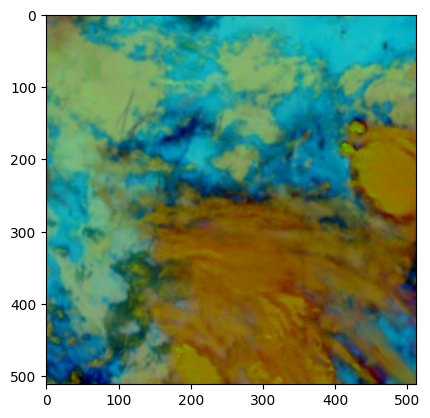

In [14]:
import matplotlib.pyplot as plt
plt.imshow(lolo['x'][1].T)

In [15]:
debug = False  # Set it to False for real training

# Data
data = Data('train', debug=debug)
data_test = Data('validation', debug=debug)
print('Data', len(data), len(data_test))

# Kfold
# nfolds = cfg['kfold']['k']
# folds = as_list(cfg['kfold']['folds'])  # list[int]
# kfold = KFold(n_splits=nfolds, shuffle=True, random_state=42)
# print('folds', folds, '/', nfolds)

# Loss
criterion = BCELoss()
dice = smp.losses.DiceLoss('binary', from_logits=True)  # just as metric in validation

# Training parameters
weight_decay = float(cfg['train']['weight_decay'])
clip_grad_norm = float(cfg['train']['clip_grad_norm'])

augment_fraction = cfg['data']['augment_prob']
steps_per_epoch = cfg['val']['per_epoch']
th_val = cfg['val']['th']
th_test = cfg['test']['th']

# Train loop
log = {}
epochs_log = []
losses_train = []
# losses_val = []
final_scores = []

n_sum = 0
loss_sum = 0.0
lrs = []

print('Pretrained: ', cfg['model']['pretrained'])

tb_global = time.time()
# for ifold, (idx_train, idx_val) in enumerate(kfold.split(data.df)):
#     if ifold not in folds:
#         continue

# Data
loader_train = data.loader( cfg, augment=True, drop_last=True, shuffle=True)
# loader_val = data.loader(idx_val, cfg)
loader_test = data_test.loader(cfg)

nbatch = len(loader_train)

# Model
model = Model(cfg, pretrained=True)
model.to(device)
model.train()

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4,
                              weight_decay=weight_decay)

scheduler = Scheduler(optimizer, cfg['scheduler'])
epochs = 4 if debug else len(scheduler)
print('%d epochs' % epochs)

tb = time.time()
dt_val = 0.0
# print('KFold %d/%d' % (ifold, nfolds))
print('       Epoch loss  dice score lr time')
for iepoch in range(epochs):
    # This is for validating multiple time per epoch
    icheck = [nbatch * (i + 1) // steps_per_epoch - 1 for i in range(steps_per_epoch)]

    for ibatch, d in enumerate(loader_train):
        x = d['x'].to(device)          # input image
        y = d['y'].to(device)          # segmentation label
        y_sym = d['y_sym'].to(device)  # symmetric label
        w = d['w'].to(device)          # w=0 if augmented, 1 if x and y are original 
        batch_size = len(x)

        optimizer.zero_grad()

        # Predict
        y_sym_pred, y_pred = model(x)  # (batch_size, 1, 256, 256)
        loss = criterion(y_sym_pred, y_sym, y_pred, y, w)

        # Backpropagate
        loss.backward()

        n_sum += batch_size
        loss_sum += batch_size * loss.item()

        nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)
        optimizer.step()

        ep = iepoch + (ibatch + 1) / nbatch
        lr = optimizer.param_groups[0]['lr']
        lrs.append((ep, lr))

        # Validation
        if ibatch == icheck[0]:
            icheck.pop(0)

            epochs_log.append(iepoch + (ibatch + 1) / nbatch)
            loss_train = loss_sum / n_sum
            losses_train.append(loss_train)

#             val = evaluate(model, loader_val, th=th_val)
            test = evaluate(model, loader_test, th=th_test)

#             losses_val.append(val['loss'])
            dt = time.time() - tb
            dt_val += test['dt']

            print('Epoch %5.2f %6.3f %.3f  %5.1e %5.1f %5.1f min' % (ep,
                  10 * loss_train
                  , test['score'],
                  lr, dt_val / 60, dt / 60))

            # Reset train loss
            n_sum = 0
            loss_sum = 0.0

        scheduler.step(ep)

# Save model
model.eval()
ofilename = '/kaggle/working/model_7_3_2024_1.pytorch' 
torch.save(model.state_dict(), ofilename)
print(ofilename, 'written')
del model

# Kfolds done
dt = time.time() - tb_global
print('Total time: %.2f min' % (dt / 60))

AssertionError: 